In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap


In [3]:
df = pd.read_csv("cristiano_vs_messi.csv")

In [4]:
df.head()

,Player,Season,Competition,Matchday,Date,Venue,Club,Opponent,Result,Playing_Position,Minute,At_score,Type,Goal_assist
0,Cristiano Ronaldo,02/03,Liga Portugal,6,2002-10-07,H,Sporting CP,Moreirense FC,3:00,LW,34,2:00,Solo run,NaN
1,Cristiano Ronaldo,02/03,Liga Portugal,6,2002-10-07,H,Sporting CP,Moreirense FC,3:00,LW,90+5,3:00,Header,Rui Jorge
2,Cristiano Ronaldo,02/03,Liga Portugal,8,2002-10-26,A,Sporting CP,Boavista FC,1:02,NaN,88,1:02,Right-footed shot,Carlos Martins
3,Cristiano Ronaldo,02/03,Taca de Portugal Placard,Fourth Round,2002-11-24,H,Sporting CP,CD Estarreja,4:01,NaN,67,3:00,Left-footed shot,Cesar Prates
4,Cristiano Ronaldo,02/03,Taca de Portugal Placard,Fifth Round,2002-12-18,H,Sporting CP,FC Oliveira do Hospital,8:01,NaN,13,3:00,NaN,NaN


In [5]:
df.shape

(1413, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Player            1413 non-null   object
 1   Season            1413 non-null   object
 2   Competition       1413 non-null   object
 3   Matchday          1413 non-null   object
 4   Date              1413 non-null   object
 5   Venue             1413 non-null   object
 6   Club              1413 non-null   object
 7   Opponent          1413 non-null   object
 8   Result            1413 non-null   object
 9   Playing_Position  1355 non-null   object
 10  Minute            1413 non-null   object
 11  At_score          1413 non-null   object
 12  Type              1397 non-null   object
 13  Goal_assist       953 non-null    object
dtypes: object(14)
memory usage: 154.7+ KB


In [7]:
# Keep only Ronaldo and Messi
df['player_lower'] = df['Player'].str.lower()
df = df[df['player_lower'].str.contains('ronaldo|messi', na=False)]

In [8]:
# Clean 'Minute' column
def convert_minute(value):
    try:
        if isinstance(value, str) and '+' in value:
            parts = value.split('+')
            return int(parts[0]) + int(parts[1])
        return int(value)
    except:
        return np.nan

df['Minute'] = df['Minute'].apply(convert_minute)
df = df.dropna(subset=['Minute'])

In [9]:
df['Player'] = df['player_lower'].apply(lambda x: 'Ronaldo' if 'ronaldo' in x else 'Messi')

# Simplified meaningful features
df['Game_Phase'] = pd.cut(df['Minute'],
                          bins=[0, 15, 45, 75, 120],
                          labels=['Early', 'Mid1', 'Mid2', 'Late'],
                          include_lowest=True)
df['Assist_Flag'] = df['Goal_assist'].notnull().astype(int)


In [10]:
# Select relevant columns (excluding leak-prone ones)
features = ['Competition', 'Venue', 'Playing_Position', 'Type', 'Minute', 'Game_Phase', 'Assist_Flag']
df = df.dropna(subset=features)


In [11]:
# Encode categorical columns
encoders = {}
for col in ['Competition', 'Venue', 'Playing_Position', 'Type', 'Game_Phase']:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col].astype(str))
    encoders[col] = enc

# Add readable categorical columns
for col, enc in encoders.items():
    df[col + '_name'] = enc.inverse_transform(df[col])


In [12]:
# Define target and features
X = df[features]
y = LabelEncoder().fit_transform(df['Player'])
# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
y

array([1, 1, 1, ..., 0, 0, 1], shape=(1348,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    gamma=0.2,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)

In [16]:
print(f"🔥 XGBoost Accuracy: {acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Messi','Ronaldo']))


🔥 XGBoost Accuracy: 90.74%

Classification Report:
               precision    recall  f1-score   support

       Messi       0.89      0.94      0.91       141
     Ronaldo       0.93      0.88      0.90       129

    accuracy                           0.91       270
   macro avg       0.91      0.91      0.91       270
weighted avg       0.91      0.91      0.91       270



In [17]:
# Cross-validation check (for robustness)
cv_scores = cross_val_score(xgb, X_scaled, y, cv=5)
print(f"\n✅ Cross-validation accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")



✅ Cross-validation accuracy: 82.20% ± 6.45%


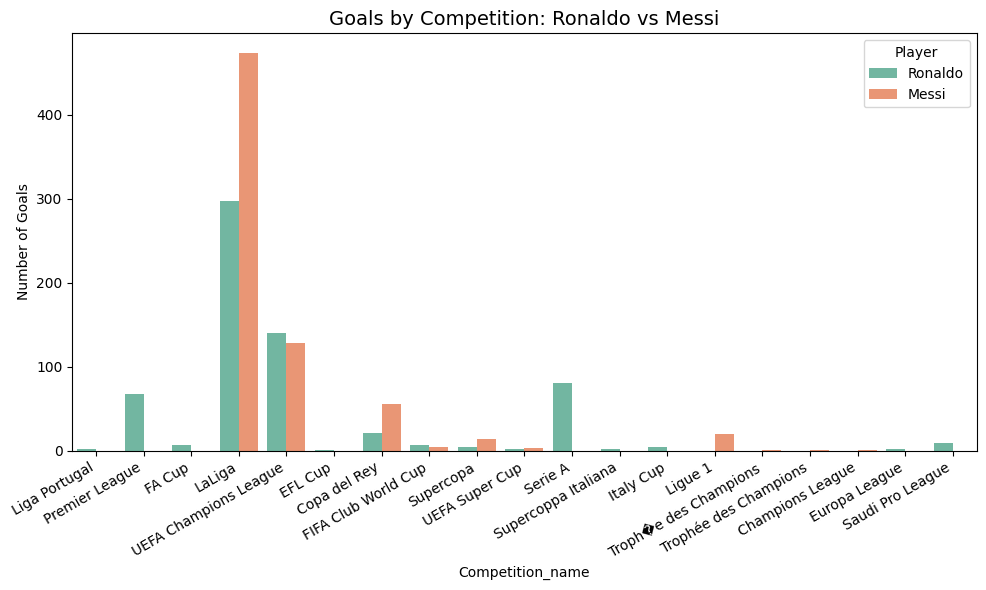

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Competition_name', hue='Player', palette='Set2')
plt.title("Goals by Competition: Ronaldo vs Messi", fontsize=14)
plt.xlabel("Competition_name")
plt.ylabel("Number of Goals")
plt.xticks(rotation=30, ha='right')
plt.legend(title="Player")
plt.tight_layout()
plt.show()

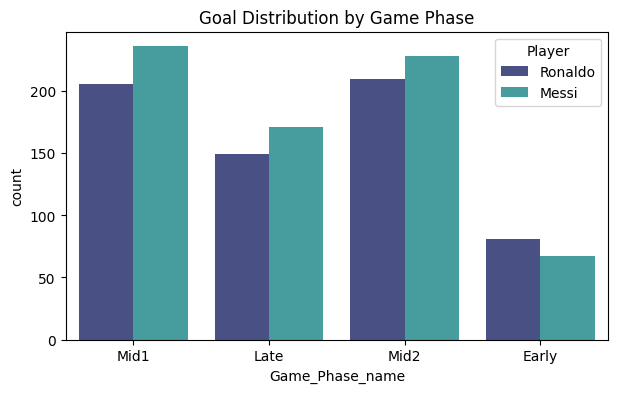

In [19]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Game_Phase_name', hue='Player', palette='mako')
plt.title("Goal Distribution by Game Phase")
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Dropdowns (without Game_Phase)
inputs = {}
for col in ['Competition', 'Venue', 'Playing_Position', 'Type']:
    key = col + '_name'
    inputs[key] = widgets.Dropdown(options=sorted(df[key].unique()), description=col+':')
    display(inputs[key])

# Minute slider
minute_slider = widgets.IntSlider(min=0, max=120, step=1, value=45, description='Minute:')
display(minute_slider)

# Assist Flag
assist_toggle = widgets.ToggleButtons(options=[('No Assist',0), ('Assist',1)], description='Assist:')
display(assist_toggle)

output = widgets.Output(); display(output)

def predict_event(_):
    with output:
        clear_output()
        row=[]
        # Order must match model: Competition, Playing_Position, Venue, Type, Game_Phase, Minute, Assist_Flag
        row.append(encoders['Competition'].transform([inputs['Competition_name'].value])[0])
        row.append(encoders['Playing_Position'].transform([inputs['Playing_Position_name'].value])[0])
        row.append(encoders['Venue'].transform([inputs['Venue_name'].value])[0])
        row.append(encoders['Type'].transform([inputs['Type_name'].value])[0])

        # Auto-detect Game Phase
        minute = minute_slider.value
        game_phase = pd.cut([minute], bins=[0,15,45,75,120], labels=['Early','Mid1','Mid2','Late'], include_lowest=True)[0]
        row.append(encoders['Game_Phase'].transform([game_phase])[0])

        # Minute (numeric)
        row.append(minute)
        # Assist Flag
        row.append(assist_toggle.value)

        pred = xgb.predict([row])
        player = list(set(df['Player']))[pred[0]]
        print(f'Predicted Goal Scorer: {player}')

btn = widgets.Button(description='Predict Scorer')
btn.on_click(predict_event)
display(btn)


Dropdown(description='Competition:', options=('Champions League', 'Copa del Rey', 'EFL Cup', 'Europa League', …

Dropdown(description='Venue:', options=('A', 'H'), value='A')

Dropdown(description='Playing_Position:', options=('AM', 'AM ', 'CF', 'CF ', 'LW', 'LW ', 'RW', 'RW ', 'SS', '…

Dropdown(description='Type:', options=('Chest', 'Counter attack goal', 'Deflected shot on goal', 'Direct free …

IntSlider(value=45, description='Minute:', max=120)

ToggleButtons(description='Assist:', options=(('No Assist', 0), ('Assist', 1)), value=0)

Output()

Button(description='Predict Scorer', style=ButtonStyle())